# Attention Architecture

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import music21

In [3]:
# from fastai.text import *
from enum import Enum
import torch

In [4]:
import numpy as np
import torch.nn as nn

In [5]:
np.set_printoptions(edgeitems=10, threshold=40, linewidth=200)

In [6]:
import sys
sys.path.insert(0, '../../')
from src.fastai_data import *
from src.encode_data import *
from src.serve import *

In [7]:
from src.music_transformer import *

In [8]:
from src.msklm import *

In [9]:
config = mlm_config(vocab)

In [10]:
# config['n_layers'] = 2
# # config['bptt'] = 512
# config['bs'] = 8
# config['mem_len'] = 32

In [11]:
config

{'ctx_len': 150,
 'n_layers': 8,
 'n_heads': 8,
 'd_model': 512,
 'd_head': 64,
 'd_inner': 2048,
 'resid_p': 0.1,
 'attn_p': 0.1,
 'ff_p': 0.1,
 'embed_p': 0.1,
 'output_p': 0.1,
 'bias': True,
 'scale': True,
 'act': <Activation.GeLU: 3>,
 'double_drop': True,
 'tie_weights': True,
 'out_bias': True,
 'init': <function fastai.text.models.transformer.init_transformer(m)>,
 'mem_len': 512,
 'mask': True,
 'pad_idx': 1,
 'bos_idx': 0,
 'sep_idx': 8,
 'transpose_range': (0, 12),
 'rand_transpose': True,
 'rand_bptt': False,
 'note_range': (9, 137),
 'bs': 16,
 'bptt': 256,
 'vocab_size': 312}

In [12]:
base_path = Path('../../data/midi/v18/sf4/')

In [13]:
cache_name = 'tmp/hook_c'
# cache_name = 'tmp/sample'

## BERT Dataloading

In [14]:
# dl_tfms = [partial(random_msklm_tfm, p_lm=1.0)]
# # dl_tfms = [random_msklm_tfm]
# msklm_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
#                               train_tfms=[to_single_stream], valid_tfms=[to_single_stream],
#                               y_offset=1, dl_tfms=dl_tfms, **config)


In [15]:
# xb,yb = msklm_data.one_batch();

## Either or Data

In [16]:
dl_tfms = [partial(mask_or_lm_tfm, p_lm=0.5)]
# dl_tfms = [random_msklm_tfm]
msklm_data = MusicDataBunch.load(base_path/'piano_duet', cache_name=cache_name, vocab=vocab, 
                              y_offset=1, dl_tfms=dl_tfms, **config)


In [17]:
xb,yb = msklm_data.one_batch();

In [18]:
xb

[None, tensor([[ 80, 149,   0,  ..., 145,  56, 145],
         [ 80, 149,   0,  ..., 145,  56, 145],
         [ 80, 149,   0,  ..., 145,  56, 145],
         ...,
         [ 80, 149,   0,  ..., 145,  56, 145],
         [ 80, 149,   0,  ..., 145,  56, 145],
         [ 80, 149,   0,  ..., 145,  56, 145]]), None, tensor([[-132, -132,    0,  ...,  -16,  -16,  -16],
         [-132, -132,    0,  ...,  -16,  -16,  -16],
         [-132, -132,    0,  ...,  -16,  -16,  -16],
         ...,
         [-132, -132,    0,  ...,  -16,  -16,  -16],
         [-132, -132,    0,  ...,  -16,  -16,  -16],
         [-132, -132,    0,  ...,  -16,  -16,  -16]])]

## S2S Dataloading

In [19]:
np.pad(np.ones((4,1)), [(1,0),(0,0)], 'constant')

array([[0.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [20]:
m2c_dl_tfms = [s2s_tfm]
m2c_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=m2c_dl_tfms,
                               shuffle_dl=True, **config)

c2m_dl_tfms = [partial(s2s_tfm, mlm_type=MLMType.C2M)]
c2m_data = MusicDataBunch.load(base_path/'s2s_encode', cache_name=cache_name, 
                               preloader_cls=S2SPreloader, dl_tfms=c2m_dl_tfms,
                               shuffle_dl=True, **config)

In [21]:
m2c_data.train_dl.dl.dataset.on_epoch_begin()
m2c_data.train_dl.dl.dataset.on_epoch_end()
xb,yb = m2c_data.one_batch(); [x.shape for x in xb], yb[0].shape

([torch.Size([16, 256]),
  torch.Size([16, 256]),
  torch.Size([16, 256]),
  torch.Size([16, 256])],
 torch.Size([16, 256]))

## Datasets

In [22]:
datasets = [msklm_data, m2c_data, c2m_data]
combined_data = CombinedData(datasets)

# datasets = [nw_data]

## MSKLM

## Load

In [23]:
# loss_func = CrossEntropyFlat(ignore_index=vocab.pad_idx)
loss_func = MLMLoss()
learn = mlm_model_learner(combined_data, config.copy(), 
# learn = mlm_model_learner(datasets[0], config.copy(), 
                           loss_func=loss_func)

In [24]:
learn.metrics = [acc_ignore_pad, mask_acc, lm_acc, c2m_acc, m2c_acc]

In [25]:
from fastai.callbacks.rnn import RNNTrainer
learn.callbacks = [c for c in learn.callbacks if not isinstance(c, RNNTrainer)]
learn.callbacks.append(MLMTrainer(learn))

In [26]:
[type(c) for c in learn.callbacks]

[src.msklm.MLMTrainer]

In [27]:
learn = learn.to_fp16()

### Training

In [32]:
# learn.lr_find(num_it=500)
# learn.recorder.plot()

In [33]:
learn.validate()

[5.877538, tensor(0.0174), tensor(0.0990), tensor(0.), tensor(0.), tensor(0.)]

In [34]:
# try_pos again - max_norm 0.5
learn.fit_one_cycle(2, 1e-3)

epoch,train_loss,valid_loss,acc_ignore_pad,mask_acc,lm_acc,c2m_acc,m2c_acc,time
0,1.347190,1.435162,0.630273,0.570464,0.604596,0.620509,0.699876,04:36
1,1.096411,0.938729,0.713003,0.642254,0.654186,0.701591,0.814382,04:38


In [60]:
learn.save('save_s2s_1')

## Load sample train

In [28]:
# load_path = base_path/'piano_duet/models/save_s2s_1.pth'
# state = torch.load(load_path, map_location='cpu')
# get_model(learn.model).load_state_dict(state['model'])
# load_path

In [29]:
# learn.load('sample_train')

## Load existing

In [28]:
saved_models = get_files(base_path/'piano_duet/models/mlm', recurse=True, extensions=['.pth']); saved_models

[PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hq/1_ep40_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hq/2_ep60_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hq/2_ep60.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hq/3_ep40.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hq/3_ep40_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/lq/1_ep24_best.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/lq/1_ep24.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/lq/2_ep16.pth'),
 PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/lq/2_ep16_best.pth')]

In [29]:
load_path = saved_models[4]
state = torch.load(load_path, map_location='cpu')
m = get_model(learn.model)

In [30]:
m.load_state_dict(state['model'])
load_path

PosixPath('../../data/midi/v18/sf4/piano_duet/models/mlm/hq/3_ep40_best.pth')

## Prediction

Prediction algo

In [31]:
csv_path = base_path/f'piano_duet/piano_duet.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0,1,2,9,10,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,section,ht_key,song_url,midi,artist,md5,numpy,ht_offset,title,midi_title,parts,genres,mxl,source,ht_mode,ht_time_signature,ht_bpm
193208,chorus,C,https://www.hooktheory.com/theorytab/view/ritc...,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,aeee134e4034e5f98bb630c56d2f7f8c,sf4/piano_duet/hooktheory/pianoroll/r/ritchie-...,0.0,la-bamba,La Bamba,chorus,"Pop,Rock",NaN,hooktheory_c,1.0,4.0,144.0


In [32]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/piano_duet/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [33]:
seed_len = 40
song_np = np.load(file)
xb = torch.tensor(song_np[:seed_len])
if torch.cuda.is_available(): xb = xb.cuda()

In [34]:
song_np.shape

(322, 2)

In [35]:
# seed_stream = npenc2stream(seed_np)
# seed_stream.show()

In [36]:
self = learn
self.model.reset()
if xb.shape == 3: xb = xb[0]
x = xb[:,0][None]
pos = xb[:,1][None]

In [41]:

def predict_nw(self, xb:Tensor, n_words:int=128,
                 temperatures:float=(1.0,1.0), min_bars=4,
                 top_k=40, top_p=0.9):
    "Return the `n_words` that come after `text`."
    self.model.reset()
    if xb.shape == 3: xb = xb[0]
    x = xb[:,0][None]
    pos = xb[:,1][None]
#     xb_pos = xb[0,1][None]
        
    seed = x.cpu().numpy().squeeze()
    yb = torch.ones_like(x)
    new_idx = []
    last_pos = pos[:, -1]
    
    sep_count = 0
    bar_len = SAMPLE_FREQ * 4 # assuming 4/4 time
    vocab = self.data.vocab

    with torch.no_grad():
        for i in progress_bar(range(n_words), leave=True):
            res = self.pred_batch(batch=((None, x, None, pos),yb))[-1][-1]

            # bar = 16 beats
            if (sep_count // 16) <= min_bars: res[vocab.bos_idx] = 0.

            # Use first temperatures value if last prediction was duration
            temperature = temperatures[0] if (len(new_idx)==0 or self.data.vocab.is_duration(new_idx[-1])) else temperatures[1]
            if temperature != 1.: res.pow_(1 / temperature)

            res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
            idx = torch.multinomial(res, 1).item()

            if new_idx and new_idx[-1]==vocab.sep_idx: 
                duration = idx - vocab.dur_range[0]
                sep_count += duration
#                 print('Updating positional encoding:', last_pos, last_pos - duration)
                last_pos = last_pos - duration # position is negative
#                 print('Bars', duration, sep_count // 16)

            if idx==vocab.bos_idx: 
                print('Predicted BOS token. Returning prediction...')
                break

            new_idx.append(idx)
            x = x.new_tensor([idx])[None]
            pos = pos.new_tensor([last_pos])[None]
    return np.array(new_idx), seed


In [42]:
out_s, seed_s = predict_nw(learn, xb, n_words=40)

In [44]:
out_s

array([ 62, 145,   8, 139,  73, 139,   8, 139,  71, 139,   8, 139,  66, 139,   8, 139,  71, 145,  67, 145,  64, 145,
        60, 145,   8, 143,  73, 138,   8, 138,  75, 138,   8, 138,  76, 138,  71, 145,  68, 145])

In [45]:
[vocab.itos[i] for i in out_s]

['n53',
 'd8',
 'xxsep',
 'd2',
 'n64',
 'd2',
 'xxsep',
 'd2',
 'n62',
 'd2',
 'xxsep',
 'd2',
 'n57',
 'd2',
 'xxsep',
 'd2',
 'n62',
 'd8',
 'n58',
 'd8',
 'n55',
 'd8',
 'n51',
 'd8',
 'xxsep',
 'd6',
 'n64',
 'd1',
 'xxsep',
 'd1',
 'n66',
 'd1',
 'xxsep',
 'd1',
 'n67',
 'd1',
 'n62',
 'd8',
 'n59',
 'd8']

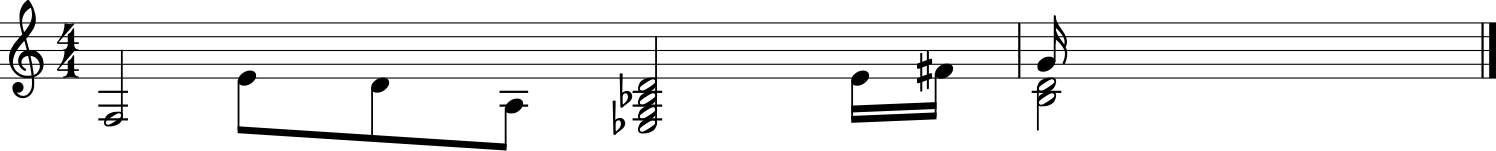

In [46]:
stream = npenc2stream(to_double_stream(out_s))
stream.show()

In [47]:
stream.show('midi')

## Predict Seq2Seq

In [48]:
csv_path = base_path/f's2s_encode/s2s_encode.csv'
csv = pd.read_csv(csv_path)
df = csv.loc[csv['numpy'].notna()];

# keywords = 'la bamba'.replace(' ', '|')
title_filter = df['title'].str.contains('la-bamba')==True
artist_filter = df['artist'].str.contains('')==True
results = df[title_filter & artist_filter]; results.head()
results = results[results.source == 'hooktheory_c']; results.head()

/home/ubuntu/anaconda3/envs/midi/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4,7,9,11,14,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,ht_mode,title,genres,source,section,midi,artist,parts,ht_bpm,midi_title,ht_time_signature,ht_key,ht_offset,md5,song_url,numpy,mxl
193164,1.0,la-bamba,"Pop,Rock",hooktheory_c,chorus,midi_sources/hooktheory/pianoroll/r/ritchie-va...,ritchie-valen,chorus,144.0,La Bamba,4.0,C,0.0,aeee134e4034e5f98bb630c56d2f7f8c,https://www.hooktheory.com/theorytab/view/ritc...,sf4/s2s_encode/hooktheory/pianoroll/r/ritchie-...,NaN


In [49]:
idx = 0
file = base_path.parent/results.numpy.values[idx];
orig = base_path.parent/results.midi.values[idx];
file, orig

(PosixPath('../../data/midi/v18/sf4/s2s_encode/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.npy'),
 PosixPath('../../data/midi/v18/midi_sources/hooktheory/pianoroll/r/ritchie-valen/la-bamba/chorus_key_cmajor.mid'))

In [50]:
melody_np, chord_np = np.load(file, allow_pickle=True)

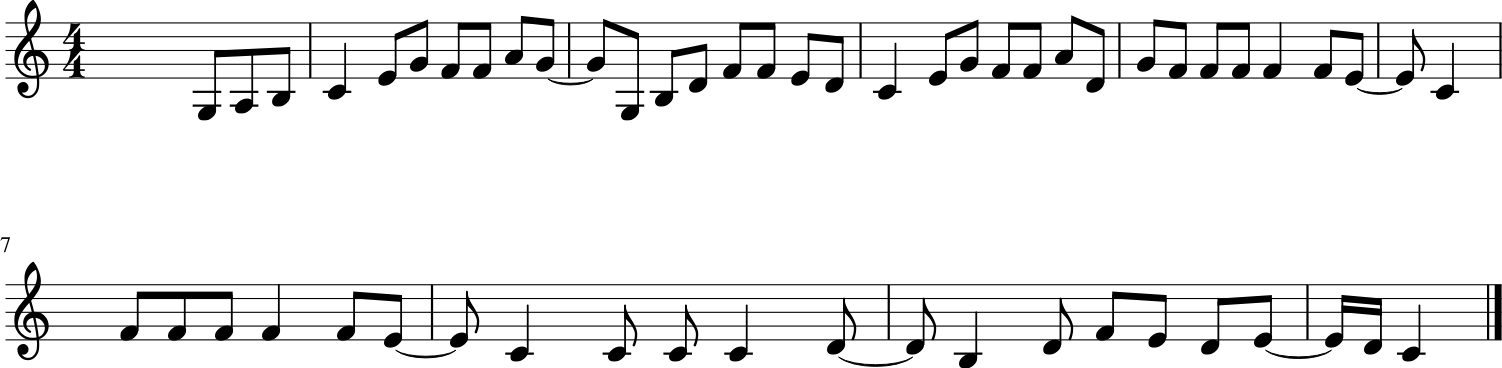

In [51]:
npenc2stream(to_double_stream(melody_np[...,0])).show()

In [52]:
melody_np

array([[   6,    0],
       [   1,    0],
       [   8,    0],
       [ 147,    0],
       ...,
       [ 138, -145],
       [  69, -146],
       [ 141, -146],
       [   2, -146]])

In [53]:
learn.model.reset()

In [62]:

def predict_s2s(self, xb_msk:Tensor, xb_lm:Tensor, n_words:int=128,
                temperatures:float=(1.0,1.0),
                top_k=40, top_p=0.9):
    self.model.reset()
    
    x_lm = xb_lm[0,:,0].tolist()
    lm_pos = xb_lm[0,:,1].tolist()
    last_pos = lm_pos[-1]
    
    x_enc = self.model.encoder(xb_msk[...,0], xb_msk[...,1])

    for i in progress_bar(range(n_words), leave=True):
        
        # Next Word
        x, pos = torch.tensor(x_lm, device=xb_lm.device)[None], torch.tensor(lm_pos, device=xb_lm.device)[None]
        dec = self.model.decoder(x, pos, x_enc) # all tasks include mask decoding
        res = F.softmax(self.model.head(dec), dim=-1)[-1, -1]

        # Use first temperatures value if last prediction was duration
        temperature = temperatures[0] if (len(x_lm)==0 or self.data.vocab.is_duration(x_lm[-1])) else temperatures[1]
        if temperature != 1.: res.pow_(1 / temperature)

        res = top_k_top_p_filtering(res, top_k=top_k, top_p=top_p, filter_value=0)
        idx = torch.multinomial(res, 1).item()
        #         idx = res.argmax()

        if idx == vocab.bos_idx | idx == vocab.stoi[EOS]: 
            print('Predicting BOS/EOS')
            break
            
        if x_lm and x_lm[-1]==vocab.sep_idx: 
            duration = idx - vocab.dur_range[0]
#             sep_count += duration
            print('Updating positional encoding:', last_pos, last_pos - duration)
            last_pos = last_pos - duration # position is negative
            
        lm_pos.append(last_pos)
        x_lm.append(idx)

    return x_lm

In [63]:
seed_len = 30
xb_msk = torch.tensor(chord_np)[None].cuda()
xb_lm = torch.tensor(melody_np[:seed_len])[None].cuda()

In [64]:
xb_msk.shape, xb_lm.shape

(torch.Size([1, 139, 2]), torch.Size([1, 30, 2]))

In [65]:
out = predict_s2s(learn, xb_msk, xb_lm)

Updating positional encoding: -24 -26
Updating positional encoding: -26 -28
Updating positional encoding: -28 -30
Updating positional encoding: -30 -40
Updating positional encoding: -40 -42
Updating positional encoding: -42 -44
Updating positional encoding: -44 -46
Updating positional encoding: -46 -50
Updating positional encoding: -50 -52
Updating positional encoding: -52 -54
Updating positional encoding: -54 -56
Updating positional encoding: -56 -58
Updating positional encoding: -58 -60
Updating positional encoding: -60 -62
Updating positional encoding: -62 -72
Updating positional encoding: -72 -74
Updating positional encoding: -74 -76
Updating positional encoding: -76 -78
Updating positional encoding: -78 -82
Updating positional encoding: -82 -84
Updating positional encoding: -84 -86
Updating positional encoding: -86 -88
Updating positional encoding: -88 -90
Updating positional encoding: -90 -92
Updating positional encoding: -92 -94
Updating positional encoding: -94 -110
Updating po

In [66]:
out

[6,
 1,
 8,
 147,
 64,
 139,
 8,
 139,
 66,
 139,
 8,
 139,
 68,
 139,
 8,
 139,
 69,
 141,
 8,
 141,
 73,
 139,
 8,
 139,
 76,
 139,
 8,
 139,
 74,
 139,
 8,
 139,
 76,
 139,
 8,
 139,
 78,
 139,
 8,
 139,
 76,
 145,
 8,
 147,
 64,
 139,
 8,
 139,
 66,
 139,
 8,
 139,
 68,
 139,
 8,
 139,
 69,
 141,
 8,
 141,
 73,
 139,
 8,
 139,
 76,
 139,
 8,
 139,
 74,
 139,
 8,
 139,
 76,
 139,
 8,
 139,
 78,
 139,
 8,
 139,
 80,
 139,
 8,
 139,
 81,
 147,
 8,
 147,
 64,
 139,
 8,
 139,
 66,
 139,
 8,
 139,
 68,
 139,
 8,
 139,
 69,
 141,
 8,
 141,
 73,
 139,
 8,
 139,
 76,
 139,
 8,
 139,
 74,
 139,
 8,
 139,
 76,
 139,
 8,
 139,
 78,
 139,
 8,
 139,
 80,
 139,
 8,
 139,
 81,
 153,
 8,
 153,
 64,
 139,
 8,
 139,
 64,
 153,
 8,
 153,
 64,
 153,
 8,
 153,
 64,
 153,
 8,
 153,
 64,
 153,
 8,
 153,
 64,
 153,
 8,
 153,
 64,
 153]

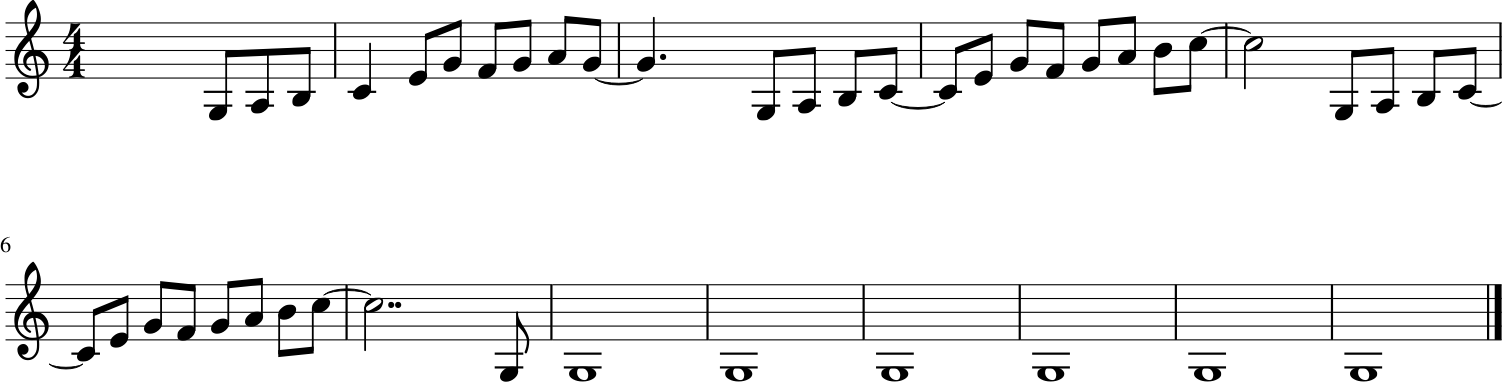

In [67]:
z_str = to_double_stream(np.array(out))
npenc2stream(z_str).show()

In [68]:
npenc2stream(z_str).show('midi')

In [202]:
yb_seed = yb[:,:3]
pad = xb.shape[-1]-yb_seed.shape[-1]

In [203]:
yb_out = predict_s2s(learn, xb, yb)

In [204]:
yb_out

tensor([[  3,   5, 273,   8, 156,  64, 147,  61, 147,  57, 147,   8, 147,  61,
         147,  57, 147,  54, 147,   8, 147,  64, 147,  61, 147,  57, 147,   8,
         147,  59, 147,  56, 147,  52, 147,   8, 147,  64, 147,  61, 147,  57,
         147,   8, 147,  61, 147,  57, 147,  54, 147,   8, 147,  64, 147,  61,
         147,  57, 147,   8, 147,  59, 147,  56, 147,  52, 147,   8, 147,  64,
         147,  61, 147,  57, 147,   8, 147,  61, 147,  57, 147,  54, 147,   8,
         147,  64, 147,  61, 147,  57, 147,   8, 147,  59, 147,  56, 147,  52,
         147,   8, 147,  64, 147,  61, 147,  57, 147,   8, 147,  61, 147,  57,
         147,  54, 147,   8, 147,  64, 147,  61, 147,  57, 147,   8, 147,  59,
         147,  56, 147,  52, 147,   8, 147,  64, 147,  61, 147,  57, 147]],
       device='cuda:0')

In [205]:
yb_test = to_double_stream(yb_out.cpu().numpy()[:,1:])

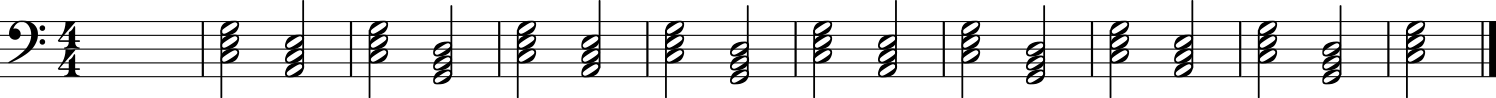

In [206]:
npenc2stream(yb_test).show()

In [207]:
npenc2stream(yb_test).show('midi')